In [591]:
import pandas as pd
import pyodbc
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta
from dateutil.rrule import rrule, MONTHLY
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import plotly.express as px
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import shap
import numdifftools as nd
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials
from hyperopt.pyll.base import scope
shap.initjs()
%load_ext autoreload
%autoreload 2
import mmm_transformations
import mmm_preprocessing
import mmm_feature_selection
import mmm_modeling
import mmm_response_curves
import mmm_optimization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Summary

In [223]:
# description of what this notebook does
# should be minimal code and jsut outputs

# Data Pull

In [515]:
conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=PRDINS10DB2;'
                      'Port=1433;')

In [516]:
sql_stmt = """SELECT [Insmed_HCP_Id], [PHYSICIAN_NPI], [CallDate_ym], MAX([PrimarySpecialty]) as Specialty, \n
                     count(distinct (case when Product in ('a0058000005VpNDAA0', 'a0058000005UplCAAS') AND Detail_Priority=1.0 then Veeva_call_Id end)) as P1_Arikayce, \n
                     count(distinct (case when Product in ('a0058000005VpNDAA0', 'a0058000005UplCAAS') AND Detail_Priority=2.0 then Veeva_call_Id end)) as P2_Arikayce, \n
                     count(distinct [PatientMasterID] ) as distinct_patients, \n
                     count(distinct [RX_NUMBER]) as rx_count \n
              FROM(SELECT a.[PatientMasterID], a.[PHYSICIAN_NPI], a.[DATE_SHIPPED], \n
                          a.RX_NUMBER, b.[InsmedID], b.[PrimarySpecialty], b.[NpiID], c.[Veeva_Call_ID], c.[Insmed_HCP_Id], \n
                          c.[Detail_Priority], c.[Product], c.[Insmed_Call_Type], c.[CallDate], LEFT(c.[CallDate], 7) AS CallDate_ym \n
                   FROM [Insmed_Adhoc].[dbo].[tblConsolidated_Dispense] a \n
                   FULL OUTER JOIN [Insmed_Adhoc].[dbo].[tblDF_Shyft_dimHCP_Adhoc] b ON A.[PHYSICIAN_NPI] = b.NpiID \n
                   FULL OUTER JOIN [Insmed_Adhoc].[dbo].[tblDF_Shyft_Call_Adhoc] c ON b.[InsmedID]= c.[Insmed_HCP_Id] \n
                   WHERE YEAR(a.[DATE_SHIPPED]) =  YEAR(c.[CallDate]) AND MONTH(a.DATE_SHIPPED) = MONTH(c.[CallDate]) \n
                   and c.Insmed_Call_Type in ('HCP and Staff','HCP Only','In Person','Live – HCP and Staff',\n
                                              'Live – HCP Only','Phone Call','Phone Call w/HCP','Phone Call w/Staff',\n
                                              'Virtual – HCP Only','Virtual Interaction')
                   and a.DISPENSE_TYPE='Product' and a.DISPENSE_STATUS not in ('V','R')) as SUBQUERY
              GROUP BY [Insmed_HCP_Id], [PHYSICIAN_NPI], [CallDate_ym]
              ORDER BY [Insmed_HCP_Id], [CallDate_ym]"""

In [517]:
df = pd.read_sql(sql_stmt, conn)
df

,Insmed_HCP_Id,PHYSICIAN_NPI,CallDate_ym,Specialty,P1_Arikayce,P2_Arikayce,distinct_patients,rx_count
0,INSP20000000,1932322948,2018-12,PUD,1,0,2,2
1,INSP20000000,1932322948,2019-02,PUD,1,0,2,2
2,INSP20000000,1932322948,2019-06,PUD,1,0,2,2
3,INSP20000000,1932322948,2019-10,PUD,1,0,6,6
4,INSP20000000,1932322948,2020-06,PUD,1,0,3,3
...,...,...,...,...,...,...,...,...
16802,INSP20134388,1144746934,2023-02,ID,0,0,1,1
16803,INSP20134500,1720513641,2023-02,ID,1,0,1,1
16804,INSP20134876,1912038944,2023-01,PHM,0,0,1,1
16805,INSP20135374,1518345289,2023-01,IMD,1,0,1,1


# Preprocessing

In [529]:
group_by = 'Specialty'
segment = 'Specialty'
date = 'CallDate_ym'
media_cols = ['P1_Arikayce', 'P2_Arikayce']
dv = 'rx_count'
preprocess = mmm_preprocessing.MMMPreprocessing(group_by, segment, date, media_cols, dv)

In [530]:
df_pp = df[[segment, date, dv] + media_cols].groupby([segment, date]).sum().reset_index().sort_values([segment, date])
df_pp = preprocess.cleanup(df_pp)
df_pp = df_pp[df_pp['CallDate_ym']<='2023-01']
df_pp

,Specialty,CallDate_ym,rx_count,P1_Arikayce,P2_Arikayce,Specialty_AC,Specialty_ADU,Specialty_CCE,Specialty_CCM,Specialty_EM,Specialty_FM,Specialty_GP,Specialty_HOS,Specialty_ID,Specialty_IM,Specialty_Other,Specialty_PCC,Specialty_PDP,Specialty_PUD
0,AC,2018-10,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,AC,2018-11,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,AC,2018-12,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,AC,2019-01,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,AC,2019-02,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,PUD,2022-09,143,94,13,0,0,0,0,0,0,0,0,0,0,0,0,0,1
737,PUD,2022-10,200,120,18,0,0,0,0,0,0,0,0,0,0,0,0,0,1
738,PUD,2022-11,185,117,14,0,0,0,0,0,0,0,0,0,0,0,0,0,1
739,PUD,2022-12,162,96,10,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [507]:
df_pp.to_csv('insmed_specialty_month_v2.csv', index=False)

In [715]:
df_pp[['Specialty', 'rx_count', 'P1_Arikayce', 'P2_Arikayce']].groupby('Specialty').mean().reset_index()

,Specialty,rx_count,P1_Arikayce,P2_Arikayce
0,AC,0.634615,0.384615,0.057692
1,ADU,3.346154,2.250000,0.038462
2,CCE,1.942308,1.038462,0.038462
3,CCM,29.057692,16.461538,0.365385
4,EM,0.750000,0.461538,0.019231
5,FM,6.461538,5.153846,0.403846
6,GP,6.538462,2.730769,0.038462
7,HOS,0.711538,0.673077,0.000000
8,ID,250.615385,166.403846,6.942308
9,IM,33.615385,20.557692,0.615385


In [323]:
np.mean(df_pp[df_pp['P1_Arikayce'] > 0]['rx_count'])

53.5992141453831

In [324]:
np.mean(df_pp[df_pp['P2_Arikayce'] > 0]['rx_count'])

129.15060240963857

In [115]:
sum(df_pp[['Specialty', 'rx_count', 'P1_Arikayce', 'P2_Arikayce']].groupby('Specialty').mean().reset_index()['P1_Arikayce'])

354.11538461538464

In [532]:
df_pp[['CallDate_ym', 'P1_Arikayce', 'P2_Arikayce']].groupby('CallDate_ym').sum().reset_index().mean()

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


P1_Arikayce    354.769231
P2_Arikayce     13.692308
dtype: float64

In [533]:
df_pp.groupby('Specialty').agg({'P2_Arikayce':['mean','max']}).reset_index()

Specialty P2_Arikayce    
                    mean max
0         AC    0.057692   1
1        ADU    0.038462   1
2        CCE    0.038462   1
3        CCM    0.365385   3
4         EM    0.019231   1
5         FM    0.403846   7
6         GP    0.038462   1
7        HOS    0.000000   0
8         ID    6.942308  26
9         IM    0.615385   5
10     Other    0.269231   2
11       PCC    0.211538   2
12       PDP    0.019231   1
13       PUD    4.673077  18

In [336]:
df_pp[['P1_Arikayce','P2_Arikayce']].describe().T

,count,mean,std,min,25%,50%,75%,max
P1_Arikayce,728.0,25.293956,55.176858,0.0,0.0,3.0,14.0,305.0
P2_Arikayce,728.0,0.972527,3.015652,0.0,0.0,0.0,0.0,26.0


In [424]:
df_pp.to_csv('insmed_segment_month_preprocessed.csv', index=False)

In [723]:
df_pp.corr()

,rx_count,P1_Arikayce,P2_Arikayce,Specialty_AC,Specialty_ADU,Specialty_CCE,Specialty_CCM,Specialty_EM,Specialty_FM,Specialty_GP,Specialty_HOS,Specialty_ID,Specialty_IM,Specialty_Other,Specialty_PCC,Specialty_PDP,Specialty_PUD
rx_count,1.000000,0.928111,0.695303,-0.134633,-0.124791,-0.129886,-0.031462,-0.134214,-0.113482,-0.113203,-0.134354,0.772756,-0.014918,-0.124372,-0.091564,-0.133028,0.507150
P1_Arikayce,0.928111,1.000000,0.539504,-0.125302,-0.115936,-0.122020,-0.044581,-0.124916,-0.101356,-0.113523,-0.123854,0.708268,-0.024015,-0.112943,-0.080114,-0.122599,0.502893
P2_Arikayce,0.695303,0.539504,1.000000,-0.084419,-0.086183,-0.086183,-0.056196,-0.087947,-0.052668,-0.086183,-0.089711,0.547088,-0.033264,-0.065016,-0.070307,-0.087947,0.338938
Specialty_AC,-0.134633,-0.125302,-0.084419,1.000000,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923
Specialty_ADU,-0.124791,-0.115936,-0.086183,-0.076923,1.000000,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923
Specialty_CCE,-0.129886,-0.122020,-0.086183,-0.076923,-0.076923,1.000000,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923
Specialty_CCM,-0.031462,-0.044581,-0.056196,-0.076923,-0.076923,-0.076923,1.000000,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923
Specialty_EM,-0.134214,-0.124916,-0.087947,-0.076923,-0.076923,-0.076923,-0.076923,1.000000,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923
Specialty_FM,-0.113482,-0.101356,-0.052668,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,1.000000,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923
Specialty_GP,-0.113203,-0.113523,-0.086183,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,1.000000,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923,-0.076923


In [726]:
fig = px.scatter(df_pp, x='P1_Arikayce', y='rx_count')
#fig.update_layout(yaxis_title="Rx Impact")
fig.show()

# Transformations

In [534]:
transform = mmm_transformations.MMMTransformations()

In [535]:
# segment level adstock
cols_to_adstock = ['P1_Arikayce', 'P2_Arikayce']
decay_rates = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8]
df_t = transform.segment_adstock_df(df_pp, cols_to_adstock, 'Specialty', decay_rates)
df_t

,Specialty,CallDate_ym,rx_count,P1_Arikayce,P2_Arikayce,Specialty_AC,Specialty_ADU,Specialty_CCE,Specialty_CCM,Specialty_EM,...,P2_Arikayce_adstock_0.35,P2_Arikayce_adstock_0.4,P2_Arikayce_adstock_0.45,P2_Arikayce_adstock_0.5,P2_Arikayce_adstock_0.55,P2_Arikayce_adstock_0.6,P2_Arikayce_adstock_0.65,P2_Arikayce_adstock_0.7,P2_Arikayce_adstock_0.75,P2_Arikayce_adstock_0.8
0,AC,2018-10,0,0,0,1,0,0,0,0,...,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000000,0.000
1,AC,2018-11,0,0,0,1,0,0,0,0,...,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000000,0.000
2,AC,2018-12,0,0,0,1,0,0,0,0,...,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000000,0.000
3,AC,2019-01,0,0,0,1,0,0,0,0,...,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000000,0.000
4,AC,2019-02,0,0,0,1,0,0,0,0,...,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000000,0.000,0.000000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,PUD,2022-09,143,94,13,0,0,0,0,0,...,18.324375,19.480,20.745625,22.125,23.621875,25.240,26.983125,28.855,30.859375,33.000
737,PUD,2022-10,200,120,18,0,0,0,0,0,...,24.338500,25.664,27.130500,28.750,30.534500,32.496,34.646500,36.998,39.562500,42.352
738,PUD,2022-11,185,117,14,0,0,0,0,0,...,22.278375,23.856,25.552625,27.375,29.329875,31.424,33.664125,36.057,38.609375,41.328
739,PUD,2022-12,162,96,10,0,0,0,0,0,...,17.662375,19.312,21.129625,23.125,25.307875,27.688,30.275125,33.079,36.109375,39.376


# Feature selection

In [536]:
feature_selection = mmm_feature_selection.MMMFeatureSelection()

In [542]:
adstock_cols = [x for x in df_t.columns if 'adstock' in x]
fs_results = feature_selection.rf(df_t, 'rx_count', ['P1_Arikayce', 'P2_Arikayce'] + adstock_cols)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [543]:
fs_results['avg_rmse'].sort_values(['avg_rmse'])

,feature,type,avg_rmse
0,P1_Arikayce_adstock_0.75,P1Arikayce,17.990298
0,P1_Arikayce_adstock_0.65,P1Arikayce,18.220308
0,P1_Arikayce_adstock_0.7,P1Arikayce,18.738968
0,P1_Arikayce_adstock_0.6,P1Arikayce,18.762386
0,P1_Arikayce_adstock_0.8,P1Arikayce,18.839260
0,P1_Arikayce_adstock_0.5,P1Arikayce,19.280825
0,P1_Arikayce_adstock_0.25,P1Arikayce,19.357373
0,P1_Arikayce,P1Arikayce,19.451534
0,P1_Arikayce_adstock_0.45,P1Arikayce,19.655592
0,P1_Arikayce_adstock_0.55,P1Arikayce,19.814237


In [544]:
best_feats = fs_results['best_feats'].copy()
best_feats

,feature,type,avg_rmse
15,P1_Arikayce_adstock_0.75,P1Arikayce,17.990298
24,P2_Arikayce_adstock_0.45,P2Arikayce,42.022463


# Final Model Fitting

In [595]:
modeling = mmm_modeling.MMMModeling()

In [629]:
# modeling
X = ['P1_Arikayce_adstock_0.65', 'P2_Arikayce_adstock_0.75'] + [x for x in df_t.columns if x.startswith('Specialty_')]
y = 'rx_count'
model = modeling.rf_regressor(df_t, X, y, 'CallDate_ym')

In [630]:
# performance
model['performance']

{'full': {'r2': 0.9964455715122772,
  'rmse': 4.555395453672959,
  'mape': 321779252755065.44},
 'test': {'r2': 0.9736902641010798,
  'rmse': 13.057615095812466,
  'mape': 597454919300884.5}}

In [631]:
# importance
model['importance']

,feature,importance,std
0,P1_Arikayce_adstock_0.65,0.947933,0.009104
10,Specialty_ID,0.017425,0.017532
1,P2_Arikayce_adstock_0.75,0.016710,0.005395
15,Specialty_PUD,0.015626,0.017239
5,Specialty_CCM,0.000999,0.000554
11,Specialty_IM,0.000476,0.000404
13,Specialty_PCC,0.000401,0.000357
7,Specialty_FM,0.000238,0.000251
8,Specialty_GP,0.000140,0.000047
12,Specialty_Other,0.000021,0.000037


In [632]:
plot_df = pd.DataFrame({'preds': model['preds_full'], 'actual': df_t[y]})
fig = px.scatter(plot_df, x="preds", y="actual")
fig.show()

# Response Curves - Isolated Impact

In [702]:
response_curves = mmm_response_curves.MMMResponseCurves()

In [664]:
X = df_t[['P1_Arikayce_adstock_0.65', 'P2_Arikayce_adstock_0.75'] + [x for x in df_t.columns if x.startswith('Specialty_')] + ['Specialty', 'CallDate_ym']]
X[['P1_Arikayce_adstock_0.65', 'P2_Arikayce_adstock_0.75']] = 0


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [665]:
# overall response curves
channel1 = response_curves.responses('overall', model['full_model'], X, 'P1_Arikayce_adstock_0.65', 200, 1, 'Specialty', 'CallDate_ym')
channel2 = response_curves.responses('overall', model['full_model'], X, 'P2_Arikayce_adstock_0.75', 200, 1, 'Specialty', 'CallDate_ym')

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

Covariance of the parameters could not be estimated


In [666]:
response_curves.plot(channel1['resp_df'], 'touches', ['P1_Arikayce_adstock_0.65', 'P1_Arikayce_adstock_0.65_hill_estimate'])

In [728]:
response_curves.plot(channel2['resp_df'], 'touches', ['P2_Arikayce_adstock_0.75', 'P2_Arikayce_adstock_0.75_hill_estimate'])

In [727]:
overall_resp = pd.concat([channel1['resp_df'], channel2['resp_df'].drop(['touches'], axis=1)], axis=1)
fig = response_curves.plot(overall_resp, 'touches', ['P1_Arikayce_adstock_0.65', 'P2_Arikayce_adstock_0.75'])
fig

In [668]:
overall_resp = pd.concat([channel1['resp_df'], channel2['resp_df'].drop(['touches'], axis=1)], axis=1)
fig = response_curves.plot(overall_resp, 'touches', ['P1_Arikayce_adstock_0.65_hill_estimate', 'P2_Arikayce_adstock_0.75_hill_estimate'])
fig

In [669]:
channel1_segment = response_curves.responses('segment', model['full_model'], X, 'P1_Arikayce_adstock_0.65', 200, 1, 'Specialty', 'CallDate_ym')

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

In [670]:
channel1_segment['fig_raw']

In [671]:
channel1_segment['fig_hill']

In [672]:
channel2_segment = response_curves.responses('segment', model['full_model'], X, 'P2_Arikayce_adstock_0.75', 200, 1, 'Specialty', 'CallDate_ym')

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame

In [673]:
plot_df = channel2_segment['resp_df'].copy()
cols = [x for x in plot_df.columns if ('adstock' in x) and ('hill' not in x)]
plot_df = plot_df[plot_df['touches'] <= 20]
fig = response_curves.plot(plot_df, 'touches', cols)
fig

In [674]:
plot_df = channel2_segment['resp_df'].copy()
cols = [x for x in plot_df.columns if x.endswith('hill_estimate')]
plot_df = plot_df[plot_df['touches'] <= 20]
fig = response_curves.plot(plot_df, 'touches', cols)
fig

In [721]:
segments = [x for x in df_t.columns if x.startswith('Specialty_')]
X = df_t[['P1_Arikayce_adstock_0.65', 'P2_Arikayce_adstock_0.75'] + segments + ['Specialty']]
X[['P1_Arikayce_adstock_0.65', 'P2_Arikayce_adstock_0.75'] + segments] = 0
channel1_v2 = response_curves.responses_segment(model['full_model'], X, 'P1_Arikayce_adstock_0.65', 200, 1, segments, 'Specialty')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [722]:
channel1_v2['fig_hill']

In [719]:
segments = [x for x in df_t.columns if x.startswith('Specialty_')]
X = df_t[['P1_Arikayce_adstock_0.65', 'P2_Arikayce_adstock_0.75'] + segments + ['Specialty']]
X[['P1_Arikayce_adstock_0.65', 'P2_Arikayce_adstock_0.75'] + segments] = 0
channel2_v2 = response_curves.responses_segment(model['full_model'], X, 'P2_Arikayce_adstock_0.75', 200, 1, segments, 'Specialty')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [720]:
channel2_v2['fig_hill']

# Budgeting - Overall

In [675]:
channel1['optimal_hill']

array([229.2045144 ,  76.30240963,   1.91050436])

In [676]:
channel2['optimal_hill']

array([1.40068725e+00, 2.85520138e-07, 1.48967165e+00])

In [677]:
overall_hill = pd.concat([pd.DataFrame(channel1['optimal_hill']).T, pd.DataFrame(channel2['optimal_hill']).T])
overall_hill['feature'] = ['P1_Arikayce_adstock_0.65','P2_Arikayce_adstock_0.75']
overall_hill.columns = ['beta', 'alpha', 'gamma', 'feature']
overall_hill

,beta,alpha,gamma,feature
0,229.204514,7.630241e+01,1.910504,P1_Arikayce_adstock_0.65
0,1.400687,2.855201e-07,1.489672,P2_Arikayce_adstock_0.75


In [678]:
optimization = mmm_optimization.MMMOptimization(budget=368, params=overall_hill)
start_vals = [100, 100]
output = optimization.optimize_hill(start_vals)
output

     fun: -219.79633027200123
     jac: array([-0.0534668 , -0.01730347])
 message: 'Iteration limit reached'
    nfev: 388
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([3.67999168e+02, 8.32177300e-04])


divide by zero encountered in double_scalars


# Budgeting - Channel 1

In [679]:
channel1_segment['optimal_hill']

{'AC_P1_Arikayce_adstock_0.65': array([230.36232497,  76.79406778,   1.90464913]),
 'ADU_P1_Arikayce_adstock_0.65': array([229.87767776,  76.76114533,   1.91065736]),
 'CCE_P1_Arikayce_adstock_0.65': array([228.25279747,  76.55084605,   1.93232623]),
 'CCM_P1_Arikayce_adstock_0.65': array([233.59063411,  79.58616696,   1.8356923 ]),
 'EM_P1_Arikayce_adstock_0.65': array([230.44403491,  76.80373   ,   1.90359553]),
 'FM_P1_Arikayce_adstock_0.65': array([222.82341522,  74.1869183 ,   2.05253562]),
 'GP_P1_Arikayce_adstock_0.65': array([225.46696343,  76.29582231,   1.9696484 ]),
 'HOS_P1_Arikayce_adstock_0.65': array([229.80944951,  76.73175847,   1.91178691]),
 'ID_P1_Arikayce_adstock_0.65': array([238.83419906,  68.97781488,   2.67772201]),
 'IM_P1_Arikayce_adstock_0.65': array([251.68164003,  84.76821901,   1.59616514]),
 'Other_P1_Arikayce_adstock_0.65': array([229.08290589,  76.58106613,   1.92217254]),
 'PCC_P1_Arikayce_adstock_0.65': array([224.34164023,  75.01661878,   2.03223664

In [680]:
params = pd.DataFrame(channel1_segment['optimal_hill']).T
params.columns = ['beta','alpha','gamma']
optimization = mmm_optimization.MMMOptimization(budget=354, params=params)
start_vals = [200,200,200,200,200,200,200,200,200,200,200,200,200,200]
output = optimization.optimize_hill(start_vals)
output

     fun: -520.2990283346778
     jac: array([-1.74842834, -1.7484436 ,  0.        ,  0.        , -1.74842834,
        0.        ,  0.        , -1.74845123,  0.        ,  0.        ,
       -1.74842072,  0.        , -1.74842072, -0.04407501])
 message: 'Optimization terminated successfully'
    nfev: 570
     nit: 40
    njev: 38
  status: 0
 success: True
       x: array([5.88930517e+01, 5.89871189e+01, 1.06123495e-15, 0.00000000e+00,
       5.88719183e+01, 0.00000000e+00, 0.00000000e+00, 5.90312028e+01,
       0.00000000e+00, 0.00000000e+00, 5.93121081e+01, 3.13256441e-16,
       5.89046003e+01, 0.00000000e+00])


# Budgeting - Channel 2

In [681]:
channel2_segment['optimal_hill']

{'AC_P2_Arikayce_adstock_0.75': array([1.13952848, 0.22325884, 3.14098355]),
 'ADU_P2_Arikayce_adstock_0.75': array([1.12685129, 0.24526972, 3.42094766]),
 'CCE_P2_Arikayce_adstock_0.75': array([1.25818503, 0.18783531, 3.30321354]),
 'CCM_P2_Arikayce_adstock_0.75': array([ 1.03939862,  0.78902436, 22.77644977]),
 'EM_P2_Arikayce_adstock_0.75': array([1.25719985, 0.24590739, 3.47492737]),
 'FM_P2_Arikayce_adstock_0.75': array([1.36850145, 0.22447828, 3.37359356]),
 'GP_P2_Arikayce_adstock_0.75': array([ 3.865     ,  0.5106028 , 13.70965758]),
 'HOS_P2_Arikayce_adstock_0.75': array([1.07597479, 0.25382035, 3.45375828]),
 'ID_P2_Arikayce_adstock_0.75': array([1.29540116, 0.23906766, 3.44423355]),
 'IM_P2_Arikayce_adstock_0.75': array([1.29540116, 0.23906766, 3.44423355]),
 'Other_P2_Arikayce_adstock_0.75': array([1.09223065, 0.2247589 , 3.09261393]),
 'PCC_P2_Arikayce_adstock_0.75': array([1.29540158, 0.22799306, 3.29257891]),
 'PDP_P2_Arikayce_adstock_0.75': array([1.20580164, 0.24713175

In [683]:
params = pd.DataFrame(channel2_segment['optimal_hill']).T
params.columns = ['beta','alpha','gamma']
optimization = mmm_optimization.MMMOptimization(budget=14, params=params)
start_vals = [1,1,1,1,1,1,1,1,1,1,1,1,1,1]
output = optimization.optimize_hill(start_vals)
output

     fun: -19.499859566886155
     jac: array([-0.02962923, -0.0296073 , -0.02965403, -0.03052807, -0.02954865,
       -0.02964354, -0.0298965 , -0.02957582, -0.02958202, -0.02958202,
       -0.02963209, -0.02959442, -0.02956247, -0.02958202])
 message: 'Optimization terminated successfully'
    nfev: 136
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.0162956 , 1.01022921, 0.87141022, 1.05508748, 1.0240868 ,
       0.99883677, 0.88932895, 1.01828233, 1.016555  , 1.016555  ,
       1.02496239, 1.02064574, 1.0211689 , 1.01655561])


# Budgeting Overall - Raw

In [684]:
optimization = mmm_optimization.MMMOptimization(budget=368)
channels =['P1_Arikayce_adstock_0.65', 'P2_Arikayce_adstock_0.75']
specialties = [x for x in df_t.columns if x.startswith('Specialty_')]
X = df_t[channels + specialties]
output = optimization.optimize_predict_overall(X, channels, 1000, model['full_model'])
output

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:42<00:00,  9.72trial/s, best loss: -24629999753.700005]


{'mix': {'P1_Arikayce_adstock_0.65': 364, 'P2_Arikayce_adstock_0.75': 20},
 'trials': [{'loss': -22336999776.63001, 'status': 'ok'},
  {'loss': -6507285649.212857, 'status': 'ok'},
  {'loss': -6265857080.198572, 'status': 'ok'},
  {'loss': -21504428356.384285, 'status': 'ok'},
  {'loss': -2388714261.827143, 'status': 'ok'},
  {'loss': -6150642795.636428, 'status': 'ok'},
  {'loss': -22268142634.46143, 'status': 'ok'},
  {'loss': -5738714228.327143, 'status': 'ok'},
  {'loss': -6129499938.705, 'status': 'ok'},
  {'loss': -20693071221.640713, 'status': 'ok'},
  {'loss': -5931928512.109286, 'status': 'ok'},
  {'loss': -20765642649.48643, 'status': 'ok'},
  {'loss': -20716928364.259277, 'status': 'ok'},
  {'loss': -19299714092.71714, 'status': 'ok'},
  {'loss': -24009428331.33429, 'status': 'ok'},
  {'loss': -22546856917.38857, 'status': 'ok'},
  {'loss': -20998285504.30285, 'status': 'ok'},
  {'loss': -5929928512.129285, 'status': 'ok'},
  {'loss': -19147999808.52, 'status': 'ok'},
  {'lo

# Budgeting Segment 1 - Raw

In [708]:
optimization = mmm_optimization.MMMOptimization(budget=368)
channels =['P1_Arikayce_adstock_0.65', 'P2_Arikayce_adstock_0.75']
specialties = [x for x in df_t.columns if x.startswith('Specialty_')]
X = df_t[channels + specialties]
X[specialties] = 0
X['Specialty_ID'] = 1
output = optimization.optimize_predict_overall(X, channels, 1000, model['full_model'])
output


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.24trial/s, best loss: -31369999686.29999]


{'mix': {'P1_Arikayce_adstock_0.65': 348, 'P2_Arikayce_adstock_0.75': 21},
 'trials': [{'loss': -24974999750.25, 'status': 'ok'},
  {'loss': -2268999977.31, 'status': 'ok'},
  {'loss': -6525999934.740001, 'status': 'ok'},
  {'loss': -21607999783.92, 'status': 'ok'},
  {'loss': -4532999954.669998, 'status': 'ok'},
  {'loss': -26358999736.410004, 'status': 'ok'},
  {'loss': -27545999724.539997, 'status': 'ok'},
  {'loss': -24944999750.549995, 'status': 'ok'},
  {'loss': -13674999863.25, 'status': 'ok'},
  {'loss': -21613999783.85999, 'status': 'ok'},
  {'loss': -26995999730.039997, 'status': 'ok'},
  {'loss': -5930999940.689999, 'status': 'ok'},
  {'loss': -26189999738.100002, 'status': 'ok'},
  {'loss': -28923999710.759995, 'status': 'ok'},
  {'loss': -28923999710.759995, 'status': 'ok'},
  {'loss': -22015999779.840004, 'status': 'ok'},
  {'loss': -12633999873.66, 'status': 'ok'},
  {'loss': -26330999736.69, 'status': 'ok'},
  {'loss': -2321999976.7799997, 'status': 'ok'},
  {'loss': -2

In [713]:
optimization = mmm_optimization.MMMOptimization(budget=368)
channels =['P1_Arikayce_adstock_0.65', 'P2_Arikayce_adstock_0.75']
specialties = [x for x in df_t.columns if x.startswith('Specialty_')]
X = df_t[channels + specialties]
X[specialties] = 0
X['Specialty_PUD'] = 1
output = optimization.optimize_predict_overall(X, channels, 1000, model['full_model'])
output

  0%|                                                                                                                           | 0/1000 [00:00<?, ?trial/s, best loss=?]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:37<00:00, 10.24trial/s, best loss: -20513999794.85999]


{'mix': {'P1_Arikayce_adstock_0.65': 226, 'P2_Arikayce_adstock_0.75': 23},
 'trials': [{'loss': -16208999837.909998, 'status': 'ok'},
  {'loss': -18801999811.980003, 'status': 'ok'},
  {'loss': -7145999928.540001, 'status': 'ok'},
  {'loss': -6571999934.280002, 'status': 'ok'},
  {'loss': -18345999816.54, 'status': 'ok'},
  {'loss': -18292999817.070007, 'status': 'ok'},
  {'loss': -6889999931.099999, 'status': 'ok'},
  {'loss': -16567999834.320005, 'status': 'ok'},
  {'loss': -16476999835.230001, 'status': 'ok'},
  {'loss': -5184999948.150001, 'status': 'ok'},
  {'loss': -6404999935.949998, 'status': 'ok'},
  {'loss': -17411999825.879997, 'status': 'ok'},
  {'loss': -12102999878.97, 'status': 'ok'},
  {'loss': -19026999809.730003, 'status': 'ok'},
  {'loss': -1183999988.16, 'status': 'ok'},
  {'loss': -7145999928.540001, 'status': 'ok'},
  {'loss': -18345999816.54, 'status': 'ok'},
  {'loss': -5310999946.89, 'status': 'ok'},
  {'loss': -6404999935.949998, 'status': 'ok'},
  {'loss': -1

# Shap

In [709]:
#Get SHAP interaction values
explainer = shap.TreeExplainer(model['full_model'])
shap_x = df_t[['P1_Arikayce_adstock_0.65', 'P2_Arikayce_adstock_0.75'] + [x for x in df_t.columns if x.startswith('Specialty_')]]
shap_interaction = explainer.shap_interaction_values(shap_x)

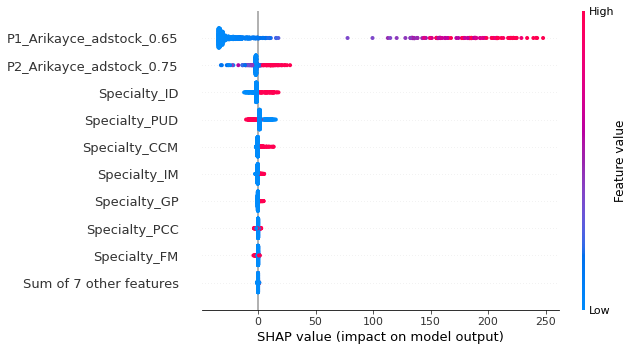

In [710]:
# Get SHAP values
shap_values = explainer(shap_x)

#Display beeswarm plot
shap.plots.beeswarm(shap_values)

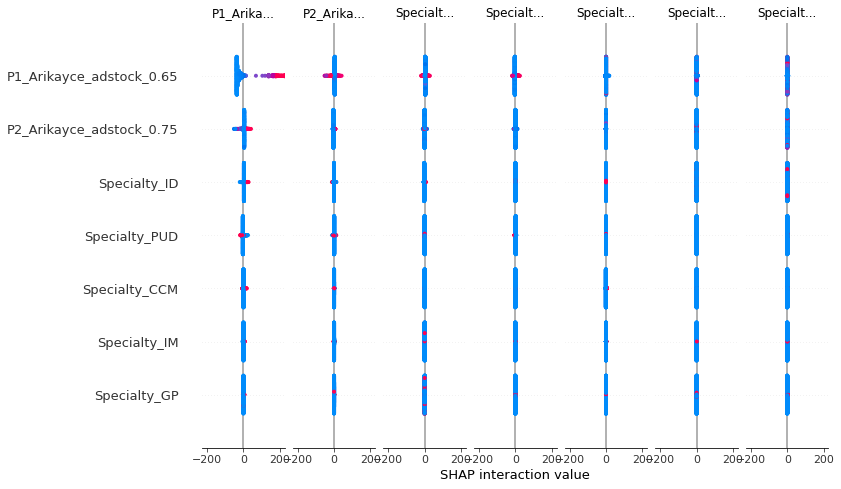

In [711]:
#Display summary plot
shap.summary_plot(shap_interaction, shap_x)

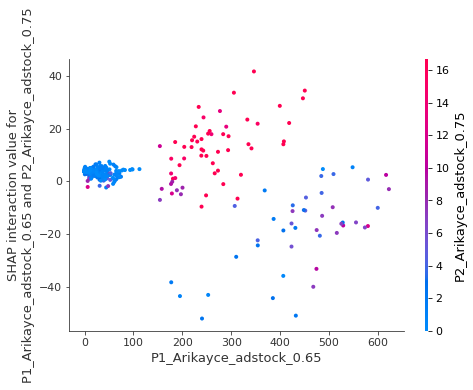

In [712]:
shap.dependence_plot(
    ("P1_Arikayce_adstock_0.65", "P2_Arikayce_adstock_0.75"),
    shap_interaction, shap_x,
    display_features=shap_x)

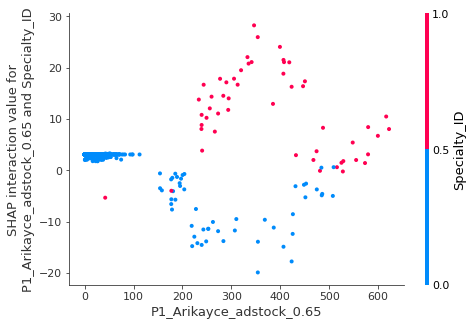

In [714]:
shap.dependence_plot(
    ("P1_Arikayce_adstock_0.65", "Specialty_ID"),
    shap_interaction, shap_x,
    display_features=shap_x)

# For troubleshooting

In [409]:
df_sim

,P1_Arikayce_adstock_0.65,P2_Arikayce_adstock_0.75,Specialty_AC,Specialty_ADU,Specialty_CCE,Specialty_CCM,Specialty_EM,Specialty_FM,Specialty_GP,Specialty_HOS,Specialty_ID,Specialty_IM,Specialty_Other,Specialty_PCC,Specialty_PDP,Specialty_PUD
0,50,60,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,50,60,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,50,60,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,50,60,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,50,60,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736,50,60,0,0,0,0,0,0,0,0,0,0,0,0,0,1
737,50,60,0,0,0,0,0,0,0,0,0,0,0,0,0,1
738,50,60,0,0,0,0,0,0,0,0,0,0,0,0,0,1
739,50,60,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [448]:
X = df_t[best_feats['feature'].tolist() + [x for x in df_t.columns if x.startswith('Specialty_')]]
channels = best_feats['feature'].tolist()
df_sim = X.copy()
budget = 100

# define function to be minimized
def objective(n):
    # n is a list containing values for each channel
    # n[0] is a value for channel 1 and n[1] is value for channel 2
    # analogous to minimizing x^2 + y^2 where x = n[0] and y = n[1]
    df_sim[channels[0]] = n[0]
    df_sim[channels[1]] = n[1]
    # get predictions to maximize (equivalent to minimizing the negative)
    # idea is to find values of n[0] and n[1] that maximize model.predict
    pred = model['full_model'].predict(df_sim)
    return -1*np.mean(pred)

# comptue jacobian
def fun_der(n):
    return nd.Jacobian(lambda n: objective(n))(n).ravel()

# compute hessian
def fun_hess(x, a):
    return nd.Hessian(lambda x: objective(n))(n)

def constraint1(n):
    return budget - n[0] - n[1]

b1 = (0,budget)
b2 = (0,budget)
           
bnds= (b1,b2)
con1 = {'type': 'ineq', 'fun': constraint1}
cons = [con1]
sol = minimize(objective, [200,200], bounds=bnds, constraints = cons, jac = fun_der, hess=fun_hess)
#sol = minimize(objective, [0,50], constraints = cons, method = 'COBYLA', jac = fun_der)

print(sol)

Method SLSQP does not use Hessian information (hess).


     fun: -44.18357142857143
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 2
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([50., 50.])


In [ ]:
# use hyperopt for grid search optmization
# maybe neural network

In [496]:
optimization = mmm_optimization.MMMOptimization(budget=368)
X = df_t[best_feats['feature'].tolist() + [x for x in df_t.columns if x.startswith('Specialty_')]]
channels = best_feats['feature'].tolist()
output = optimization.optimize_predict_overall(X, channels, 1000, model['full_model'])
output

 ... (more hidden) ...


{'mix': {'P1_Arikayce_adstock_0.65': 346, 'P2_Arikayce_adstock_0.75': 19},
 'trials': [{'loss': -3608785678.197857, 'status': 'ok'},
  {'loss': -13769428433.734283, 'status': 'ok'},
  {'loss': -22123785493.047863, 'status': 'ok'},
  {'loss': -19328285521.002857, 'status': 'ok'},
  {'loss': -2819999971.7999997, 'status': 'ok'},
  {'loss': -21862214067.09214, 'status': 'ok'},
  {'loss': -19533999804.660004, 'status': 'ok'},
  {'loss': -20322785511.057858, 'status': 'ok'},
  {'loss': -20299714082.717144, 'status': 'ok'},
  {'loss': -4879214236.922142, 'status': 'ok'},
  {'loss': -24564214040.07214, 'status': 'ok'},
  {'loss': -19233785521.94786, 'status': 'ok'},
  {'loss': -4879214236.922142, 'status': 'ok'},
  {'loss': -578142851.3614285, 'status': 'ok'},
  {'loss': -18827428383.154285, 'status': 'ok'},
  {'loss': -5909571369.475713, 'status': 'ok'},
  {'loss': -22848214057.232143, 'status': 'ok'},
  {'loss': -575142851.3914286, 'status': 'ok'},
  {'loss': -22264642634.49642, 'status': '

In [490]:
# hyperopt
X = df_t[best_feats['feature'].tolist() + [x for x in df_t.columns if x.startswith('Specialty_')]]
channels = best_feats['feature'].tolist()
df_sim = X.copy()
budget = 368

space = {}
for i in channels:
    space.update({i: hp.choice(i, range(budget))})


# define function to be minimized
def objective(n):
    for c in channels:
        df_sim[c] = n[c]
    pred = model['full_model'].predict(df_sim)
    imp = np.mean(pred)
    if sum([n[x] for x in channels]) != budget:
        imp = imp*99999999
    return -1*imp

#trials = Trials()
#best = fmin(fn=objective, space = space, algo=tpe.suggest, max_evals=2000, trials=trials)
best = fmin(fn=objective, space = space, algo=tpe.suggest, max_evals=100)

print(best)

 ... (more hidden) ...
{'P1_Arikayce_adstock_0.65': 360, 'P2_Arikayce_adstock_0.75': 24}


In [487]:
# hyperopt
X = df_t[best_feats['feature'].tolist() + [x for x in df_t.columns if x.startswith('Specialty_')]]
channels = best_feats['feature'].tolist()
df_sim = X.copy()
budget = 368

space = {
    "channel1": hp.choice("channel1", range(budget)),
    "channel2": hp.choice("channel2", range(budget)),
}


# define function to be minimized
def objective(n):
    df_sim[channels[0]] = n['channel1']
    df_sim[channels[1]] = n['channel2']
    pred = model['full_model'].predict(df_sim)
    imp = np.mean(pred)
    if sum([n[x] for x in ['channel1','channel2']]) != budget:
        imp = imp*99999999
    return -1*imp

#trials = Trials()
#best = fmin(fn=objective, space = space, algo=tpe.suggest, max_evals=2000, trials=trials)
best = fmin(fn=objective, space = space, algo=tpe.suggest, max_evals=100)

print(best)

 ... (more hidden) ...
{'channel1': 345, 'channel2': 53}


In [474]:
trials.results

[{'loss': -20322785511.057858, 'status': 'ok'},
 {'loss': -21293285501.352856, 'status': 'ok'},
 {'loss': -6459499935.405, 'status': 'ok'},
 {'loss': -21162785502.657852, 'status': 'ok'},
 {'loss': -22795285486.332855, 'status': 'ok'},
 {'loss': -6552999934.47, 'status': 'ok'},
 {'loss': -2071357122.1435714, 'status': 'ok'},
 {'loss': -20463428366.79429, 'status': 'ok'},
 {'loss': -22209714063.617146, 'status': 'ok'},
 {'loss': -1261714273.0971427, 'status': 'ok'},
 {'loss': -22232499777.675003, 'status': 'ok'},
 {'loss': -1139071417.1807141, 'status': 'ok'},
 {'loss': -21836571210.20571, 'status': 'ok'},
 {'loss': -23593571192.63572, 'status': 'ok'},
 {'loss': -20936071219.210712, 'status': 'ok'},
 {'loss': -22107214064.64214, 'status': 'ok'},
 {'loss': -6725214218.462143, 'status': 'ok'},
 {'loss': -22096714064.747143, 'status': 'ok'},
 {'loss': -23167142625.47143, 'status': 'ok'},
 {'loss': -20356499796.435, 'status': 'ok'},
 {'loss': -5909571369.475713, 'status': 'ok'},
 {'loss': -

In [406]:
%load_ext autoreload
%autoreload 2
import mmm_optimization

optimization = mmm_optimization.MMMOptimization(budget=200)

X = df_t[best_feats['feature'].tolist() + [x for x in df_t.columns if x.startswith('Specialty_')]]
channels = best_feats['feature'].tolist()
start_vals = [200, 200]
optimization.optimize_predict(X, start_vals, channels, model['full_model'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


     fun: -64.2992857142857
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([100., 100.])

In [402]:
budget = 368
def objective(n):
    return -1*(224.95815446*(1/(1+(n[0]/ 70.88233024)**(-1.92321704))) +
               8.75183774*(1/(1+(n[1]/ 2.65540461)**(-2.91539855 ))))
               
def constraint1(n):
    return budget - n[0] - n[1]

b1 = (0,budget)
b2 = (0,budget)
           
bnds= (b1,b2)
con1 = {'type': 'ineq', 'fun': constraint1}
cons = [con1]
sol = minimize(objective, [200,200], bounds=bnds, constraints = cons)

print(sol)

     fun: -223.9684596327061
     jac: array([-0.04922867, -0.04921532])
 message: 'Optimization terminated successfully'
    nfev: 74
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([357.89141085,  10.10858915])


divide by zero encountered in double_scalars


In [384]:
budget = 368
X = df_t[best_feats['feature'].tolist() + [x for x in df_t.columns if x.startswith('Specialty_')] + ['Specialty', 'CallDate_ym']]
df_sim = X.copy()

def objective(n):
    df_sim['P1_Arikayce_adstock_0.65'] = n[0]
    df_sim['P2_Arikayce_adstock_0.75'] = n[1]
    pred = model['full_model'].predict(df_sim.drop([segment, date], axis=1))
    return np.mean(pred)
                  
def constraint1(n):
    return budget - n[0] - n[1]

b1 = (0,budget)
b2 = (0,budget)
               
bnds= (b1,b2)
con1 = {'type': 'ineq', 'fun': constraint1}
cons = [con1]
sol = minimize(objective, [200,200], bounds=bnds, constraints = cons)

print(sol)

     fun: 194.56
     jac: array([0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 6
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([184., 184.])


In [385]:
objective([200,200])

194.4407142857143

In [377]:
preds(1, 'P1_Arikayce_adstock_0.65')

2.2096501831501834

In [363]:
budget = 354
X = df_t[best_feats['feature'].tolist() + [x for x in df_t.columns if x.startswith('Specialty_')] + ['Specialty', 'CallDate_ym']]

def preds(n, col):
    df_sim = X.copy()
    df_sim['P1_Arikayce_adstock_0.65'] = n
    pred = model['full_model'].predict(df_sim.drop([segment, date], axis=1))
    df_sim['preds'] = pred
    df_aggr = df_sim.drop([date], axis=1).groupby('Specialty').mean().reset_index()
    return float(df_aggr[df_aggr['Specialty'] == col]['preds'])
             
def objective(n):
    return -1*(preds(n[0], 'AC') + preds(n[1], 'ADU') + preds(n[2], 'CCE') + preds(n[3], 'CCM') + preds(n[4], 'EM')
              + preds(n[5], 'FM') + preds(n[6], 'GP') + preds(n[7], 'HOS') + preds(n[8], 'ID') + preds(n[9], 'IM')
              + preds(n[10], 'Other') + preds(n[11], 'PCC') + preds(n[12], 'PDP') + preds(n[13], 'PUD'))
               
def constraint1(n):
    return budget - n[0] - n[1] - n[2] - n[3] - n[4] - n[5] - n[6] - n[7] - n[8] - n[9] - n[10] - n[11] - n[12] - n[13]

b1 = (0,budget)
b2 = (0,budget)
b3 = (0,budget)
b4 = (0,budget)
b5 = (0,budget)
b6 = (0,budget)
b7 = (0,budget)
b8 = (0,budget)
b9 = (0,budget)
b10 = (0,budget)
b11 = (0,budget)
b12 = (0,budget)
b13 = (0,budget)
b14 = (0,budget)
               
bnds= (b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14)
con1 = {'type': 'ineq', 'fun': constraint1}
cons = [con1]
sol = minimize(objective, [200,200,200,200,200,200,200,200,200,200,200,200,200,200], bounds=bnds, constraints = cons)

print(sol)

     fun: -277.1338461538461
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 30
     nit: 2
    njev: 2
  status: 0
 success: True
       x: array([25.28571432, 25.28571432, 25.28571432, 25.28571432, 25.28571432,
       25.28571432, 25.28571432, 25.28571432, 25.28571432, 25.28571432,
       25.28571432, 25.28571432, 25.28571432, 25.28571432])


In [403]:
budget = 354
def objective(n):
    return -1*(238.21495436*(1/(1+(n[0]/ 80.77228074)**(-1.67998268))) +
                238.35181683*(1/(1+(n[1]/ 80.90369167)**(-1.6822988 ))) +
                236.07093115*(1/(1+(n[2]/ 80.43096011)**(-1.70447764))) +
                226.62173416*(1/(1+(n[3]/ 76.34025582)**(-1.78883145))) +
                239.07016048*(1/(1+(n[4]/ 80.86920095)**(-1.67748631))) +
                219.6962741 *(1/(1+(n[5]/ 71.19842807)**(-1.96818081))) +
                228.9308893 *(1/(1+(n[6]/ 79.45665337)**(-1.78030471))) +
                238.6393164 *(1/(1+(n[7]/ 80.73348852)**(-1.68474577))) +
                265.49743635*(1/(1+(n[8]/ 61.38341204)**(-3.07845064))) +
                223.42840614*(1/(1+(n[9]/ 70.66479933)**(-1.86275942))) +
                226.78522329*(1/(1+(n[10]/74.32650916)**(-1.82379646))) +
                219.15211511*(1/(1+(n[11]/73.37926068)**(-1.9767397 ))) +
                238.86810511*(1/(1+(n[12]/80.82960062)**(-1.67949901))) +
                192.41643558*(1/(1+(n[13]/51.93846613)**(-2.53538245))))
               
def constraint1(n):
    return budget - n[0] - n[1] - n[2] - n[3] - n[4] - n[5] - n[6] - n[7] - n[8] - n[9] - n[10] - n[11] - n[12] - n[13]

b1 = (0,budget)
b2 = (0,budget)
b3 = (0,budget)
b4 = (0,budget)
b5 = (0,budget)
b6 = (0,budget)
b7 = (0,budget)
b8 = (0,budget)
b9 = (0,budget)
b10 = (0,budget)
b11 = (0,budget)
b12 = (0,budget)
b13 = (0,budget)
b14 = (0,budget)
               
bnds= (b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14)
con1 = {'type': 'ineq', 'fun': constraint1}
cons = [con1]
sol = minimize(objective, [200,200,200,200,200,200,200,200,200,200,200,200,200,200], bounds=bnds, constraints = cons)

print(sol)

     fun: -623.5111370845968
     jac: array([ 0.        ,  0.        ,  0.        ,  0.        , -1.75976562,
        0.        ,  0.        ,  0.        , -1.75959778, -1.75968933,
       -1.75949097,  0.        , -1.75947571, -1.75964355])
 message: 'Optimization terminated successfully'
    nfev: 777
     nit: 52
    njev: 51
  status: 0
 success: True
       x: array([0.00000000e+00, 2.04441143e-15, 0.00000000e+00, 0.00000000e+00,
       4.56234418e+01, 3.65538762e-16, 1.86344453e-15, 4.04380305e-16,
       8.74643595e+01, 5.67166391e+01, 5.41017277e+01, 0.00000000e+00,
       4.56913120e+01, 6.44025199e+01])


divide by zero encountered in double_scalars


In [404]:
objective([4, 10, 6, 37, 4, 22, 13, 3, 305, 56, 15, 20, 6, 248])

-661.4428058894908

# Next Steps

In [ ]:
# based on prior data here is how to optimize touches
# intro slides on promotion response
# then go through notebook
# check how this is changing if we shorten the time frame within a year - 3 months, 6 months within the same marketing campaign
# get avg rmse for other adstocks
# plot a density of adstock decay rates
# get performance on hold out set